In [21]:
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

sys.path.append('../src')

import columnar as col

ROOT_PATH = '../'

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing Mean Target Encoding vs categorical data embeddings
## Prediction Task
Predict whether an adult's income is higher or lower than $50k, using census information

### Dataset
We are leveraging the Adult dataset, which provides various census features about individuals and aims to predict whether an individual is earning over $50k or not.
[https://archive.ics.uci.edu/ml/datasets/Adult](https://archive.ics.uci.edu/ml/datasets/Adult)

### Definitions
* **Mean Target Encoding** is a technique to transform categorical data into numerical by replacing the categorical value by the mean target value for all observations belonging to that category.
* **Categorical data embeddings** is a potentially more expressive generalization of MTE which represents each categorical value as an embedding. embeddings sizes can be defined based on the cardinality of each feature. An embedding of size 1 should replicate closely the principle of MTE (even though values are learnt more indireclty), but weights are learnt instead of explicitly defined.

## Load Data

In [22]:
loader = col.DataLoader(task='adults', root=ROOT_PATH)
df = loader.load_data()
display(df.sample(5))

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours-per-week,native-country,income,target
26033,67,Self-emp-not-inc,217892,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,10605,0,35,United-States,>50K,True
8899,65,Private,196174,10th,6,Divorced,Handlers-cleaners,Not-in-family,White,Female,0,0,28,United-States,<=50K,False
20927,25,Private,176162,Bachelors,13,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K,False
11749,35,Private,265954,Bachelors,13,Never-married,Handlers-cleaners,Not-in-family,Black,Male,0,0,40,United-States,<=50K,False
23814,41,Self-emp-not-inc,145441,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Yugoslavia,<=50K,False


## Define Metrics for Success

In [3]:
# define scoring metrics of interest
scorer = col.Scorer(
    acc=metrics.accuracy_score,
    f1=metrics.f1_score,
    auc=metrics.roc_auc_score,
)

# create a reporting object
reporter = col.Report(scorer=scorer)

# define which columns should be shown when reporting experiments results so far
reporter.set_columns_to_show(['encoder'] + list(scorer.scoring_fcts.keys()))

print(reporter)

Report(
        scorer: Scorer(scoring_fcts=[acc,f1,auc]), 
        to_show: [encoder,acc,f1,auc]
        )


## Define Cross Validation Strategy

In [4]:
# cross validation strategy
kf = KFold(n_splits=5)

## Feature Selection and Processing
* define which variables should be fed into the downstream classifiers, and which ones should be considered as categorical or numerical.
* pass through all numerical variables

In [5]:
feature_selection = loader.get_selected_features(df)

print(feature_selection)

FeatureSelection(categoricals=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], numericals=['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours-per-week'], target='target')


## Model Selection and Fitting

In [6]:
# define fitting function
mte_encoder = col.MeanTargetEncoder(feature_selection)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=mte_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score, show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851878,0.626548,0.7372


## Compare to Baseline
### Baseline 1: Assign all predictions to majority class

In [7]:
# baseline: assign all predictions to majority class
maj_results = pd.DataFrame([reporter.score(df.target, np.zeros(len(df))) for _ in range(5)])
maj_config = dict(features=str(feature_selection),
                  encoder='MajorityClass',
                  model='Nonę',
                  scaler='None'
                 )

reporter.add_to_report(maj_config, maj_results, show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851878,0.626548,0.7372
1,MajorityClass,0.759190,0.000000,0.5000


## Baseline 2: one hot encode all categories

In [8]:
from sklearn.preprocessing import OneHotEncoder

# define fitting function
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=ohe_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score, show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851878,0.626548,0.737200
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.838181,0.553344,0.694219


## Baseline 3: OrdinalEncoder

In [9]:
from sklearn.preprocessing import OrdinalEncoder

# define fitting function
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=ord_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score, show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851878,0.626548,0.737200
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.838181,0.553344,0.694219
3,OrdinalEncoder(handle_unknown='use_encoded_val...,0.850189,0.615975,0.730317


In [10]:
pd.pivot(reporter.report, index='model', columns='encoder', values='acc')

encoder,MajorityClass,"MeanTargetEncoder(target=target, alpha=5)",OneHotEncoder(handle_unknown='ignore'),"OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)"
model,,,,
Nonę,0.75919,NaN,NaN,NaN
RandomForestClassifier(max_depth=5),NaN,0.851878,0.838181,0.850189


## Inspect MTE output

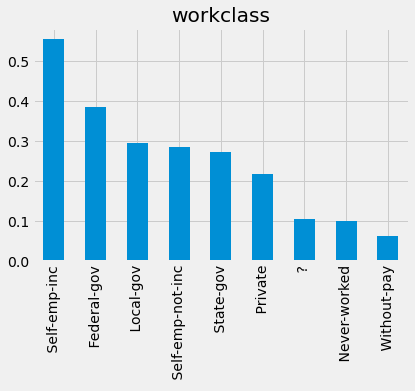

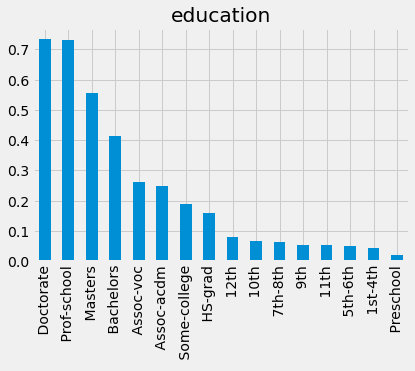

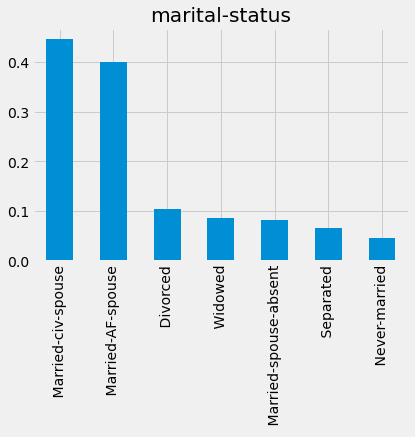

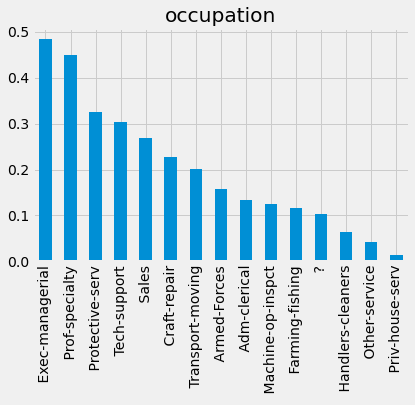

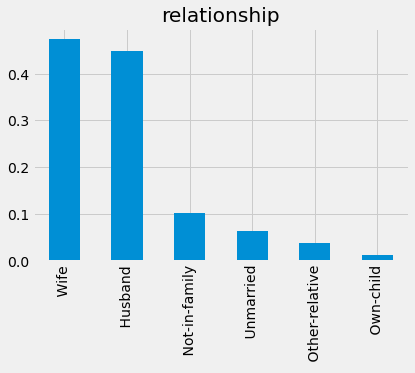

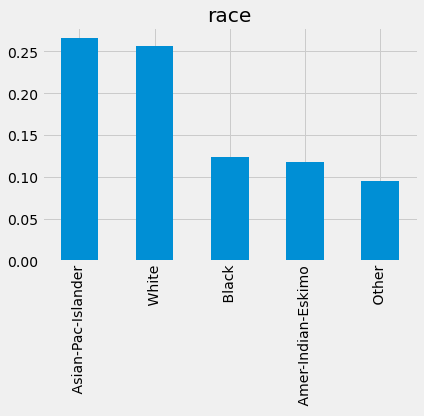

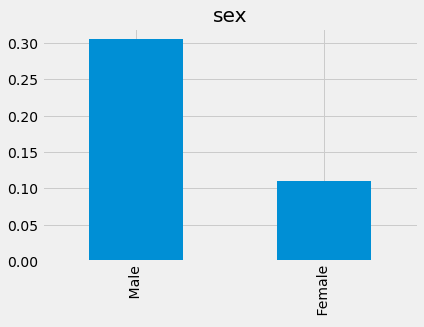

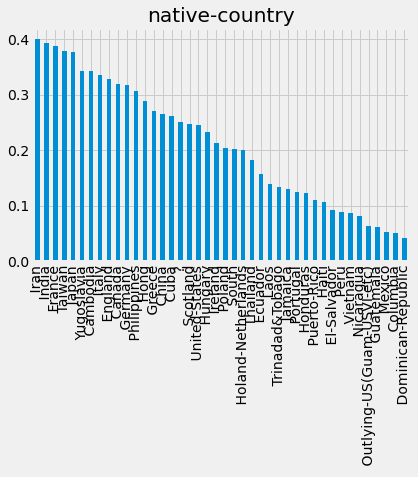

In [20]:
# define fitting function
mte_encoder = col.MeanTargetEncoder(feature_selection)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=mte_encoder)

# train model on entire dataset (no CV)
pipe.fit(df)



# get Mean Target Encoder learned weights for each categorical variable:
mapper = pipe.pipe[0].named_transformers_['categories'].mapper
for k, v in mapper.items():
    pd.Series(v).sort_values(ascending=False).plot.bar()
    plt.title(k)
    plt.show()


## Plot Feature Importance

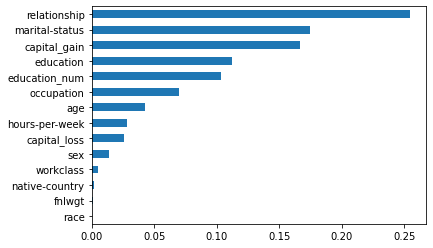

<Figure size 432x288 with 0 Axes>

In [14]:
def plot_feature_importance(pipe: col.CategoricalPipeline, *args, **kwargs):
    fi = (pd.Series(pipe.model.feature_importances_, 
                   index=pipe.features.categoricals + pipe.features.numericals)
          .sort_values())
    fi.plot.barh(*args, **kwargs)
    plt.show()


col.plot_feature_importance(pipe)
plt.savefig('../figures/feature_importance.png', facecolor='white');

In [15]:
# number of unique values for each categorical column
{col: df[col].nunique() for col in feature_selection.categoricals}

{'workclass': 9,
 'education': 16,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 42}

# Compare value of MTE for linear models vs non-linear (RandomForest)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from lightgbm import LGBMClassifier
from sklearn.base import clone

reporter = col.Report(scorer=scorer)
reporter.set_columns_to_show(['model', 'encoder'] + list(scorer.scoring_fcts.keys()))

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5),
    LogisticRegression(max_iter=500),
    KNeighborsClassifier(n_neighbors=5),
    LGBMClassifier()
]

encoders = [
    col.MeanTargetEncoder(feature_selection),
    OneHotEncoder(handle_unknown='ignore'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
]

for model in models:
    for encoder in encoders:
        pipe = col.CategoricalPipeline(features=feature_selection,
                                       model=clone(model),
                                       scaler=MaxAbsScaler(),
                                       encoder=clone(encoder))

        cv_score = col.cv_score(pipeline=pipe,
                                data=df, 
                                kf=kf,
                                scorer=reporter.scorer)
        
        reporter.add_to_report(pipe.config, cv_score, show=False)
        
reporter.show()

,model,encoder,acc,f1,auc
0,RandomForestClassifier(max_depth=5),"MeanTargetEncoder(target=target, alpha=5)",0.852400,0.628353,0.738325
1,RandomForestClassifier(max_depth=5),OneHotEncoder(handle_unknown='ignore'),0.838181,0.554504,0.694786
2,RandomForestClassifier(max_depth=5),OrdinalEncoder(handle_unknown='use_encoded_val...,0.849513,0.612035,0.727779
3,LogisticRegression(max_iter=500),"MeanTargetEncoder(target=target, alpha=5)",0.845429,0.639919,0.751560
4,LogisticRegression(max_iter=500),OneHotEncoder(handle_unknown='ignore'),0.850220,0.656654,0.763041
5,LogisticRegression(max_iter=500),OrdinalEncoder(handle_unknown='use_encoded_val...,0.822978,0.545481,0.692627
6,KNeighborsClassifier(),"MeanTargetEncoder(target=target, alpha=5)",0.828845,0.620366,0.744162
7,KNeighborsClassifier(),OneHotEncoder(handle_unknown='ignore'),0.825958,0.616923,0.742695
8,KNeighborsClassifier(),OrdinalEncoder(handle_unknown='use_encoded_val...,0.824484,0.611581,0.738963
9,LGBMClassifier(),"MeanTargetEncoder(target=target, alpha=5)",0.872056,0.710777,0.797303


### plot the 3 metrics for each model / encoder pair

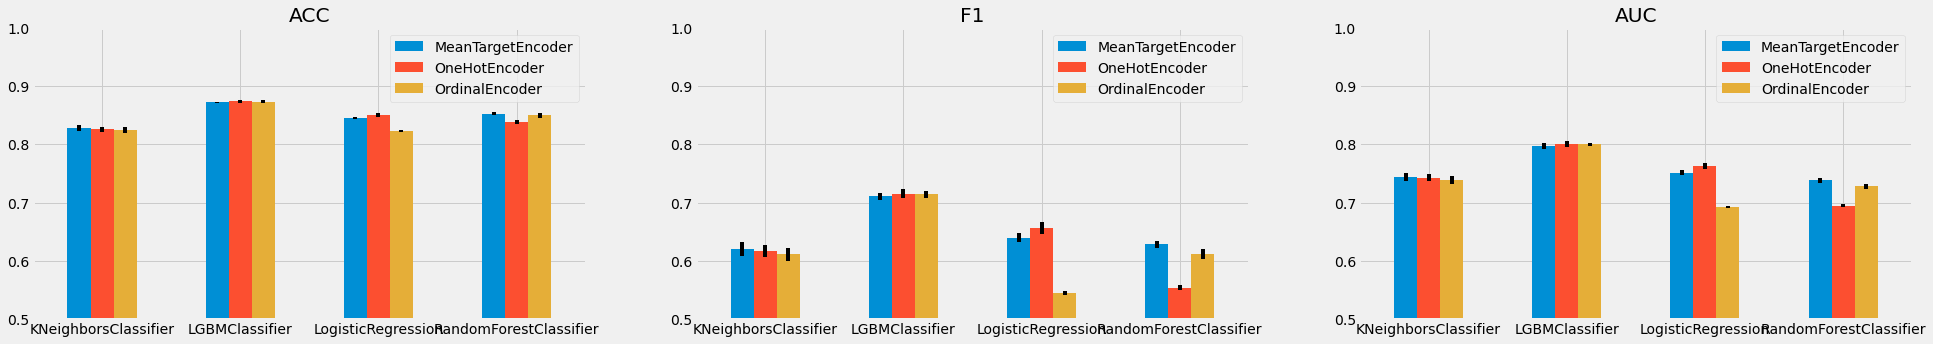

In [18]:
plt.style.use('fivethirtyeight')
col.plot_model_encoder_pairs(reporter, figpath=f'../figures/model_encoder_comparison.png')